In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.8.0


In [2]:
df = pd.read_csv('data/JNJ.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-09-04,2.937500,2.960938,2.929688,2.953125,0.182094,4188800
1,1985-09-05,2.953125,2.992188,2.945313,2.976563,0.183539,6176000
2,1985-09-06,2.992188,3.000000,2.976563,2.992188,0.184502,6606400
3,1985-09-09,2.992188,2.992188,2.945313,2.945313,0.181612,3150400
4,1985-09-10,2.953125,2.960938,2.867188,2.875000,0.177276,2841600


In [4]:
df = df[['Date', 'Close']]

In [5]:
df.dtypes

Date      object
Close    float64
dtype: object

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [8]:
df['Date'].min(), df['Date'].max()

(Timestamp('1985-09-04 00:00:00'), Timestamp('2020-09-03 00:00:00'))

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Johnson and Johnson Stock Price 1985-2020')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [11]:
train, test = df.loc[df['Date'] <= '2013-09-03'], df.loc[df['Date'] > '2013-09-03']

In [12]:
train.tail()

,Date,Close
7054,2013-08-27,86.169998
7055,2013-08-28,86.529999
7056,2013-08-29,86.570000
7057,2013-08-30,86.410004
7058,2013-09-03,86.419998


In [13]:
test.head()

,Date,Close
7059,2013-09-04,86.900002
7060,2013-09-05,87.040001
7061,2013-09-06,87.160004
7062,2013-09-09,87.559998
7063,2013-09-10,88.529999


In [14]:
train.shape,test.shape

((7059, 2), (1764, 2))

In [15]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

C:\Users\Lucas Silva\AppData\Local\Temp\ipykernel_5648\1980345901.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lucas Silva\AppData\Local\Temp\ipykernel_5648\1980345901.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

In [17]:
print(f'Training shape: {X_train.shape}')

print(f'Testing shape: {X_test.shape}')

Training shape: (7029, 30, 1)
Testing shape: (1734, 30, 1)


In [18]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

In [19]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
198/198 [==============================] - 9s 34ms/step - loss: 0.1415 - val_loss: 0.2188
Epoch 2/100
198/198 [==============================] - 6s 29ms/step - loss: 0.1118 - val_loss: 0.1777
Epoch 3/100
198/198 [==============================] - 6s 29ms/step - loss: 0.0837 - val_loss: 0.1316
Epoch 4/100
198/198 [==============================] - 5s 26ms/step - loss: 0.0788 - val_loss: 0.1063
Epoch 5/100
198/198 [==============================] - 5s 27ms/step - loss: 0.0812 - val_loss: 0.1183
Epoch 6/100
198/198 [==============================] - 5s 27ms/step - loss: 0.0906 - val_loss: 0.1440
Epoch 7/100
198/198 [==============================] - 5s 27ms/step - loss: 0.0975 - val_loss: 0.1297


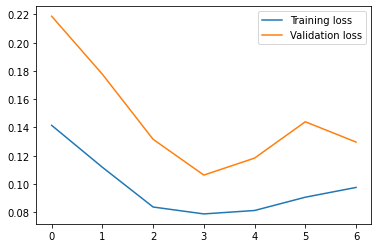

In [22]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [23]:
model.evaluate(X_test, y_test)

55/55 [==============================] - 1s 13ms/step - loss: 0.8516


0.851621150970459

Reconstruction error threshold: 0.7658653005194344


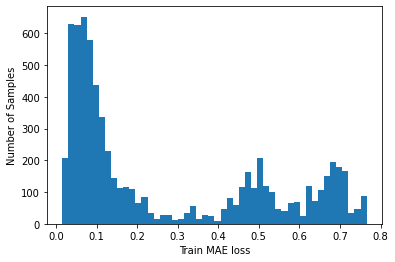

In [24]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

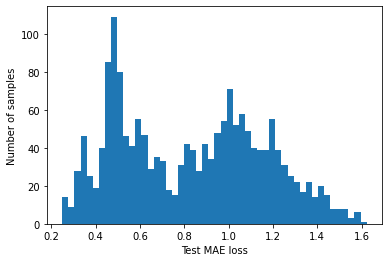

In [25]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [26]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

In [27]:
test_score_df.tail()

,Date,Close,loss,threshold,anomaly
8818,2020-08-28,4.690756,1.356029,0.765865,True
8819,2020-08-31,4.681455,1.353535,0.765865,True
8820,2020-09-01,4.605024,1.355284,0.765865,True
8821,2020-09-02,4.698440,1.369022,0.765865,True
8822,2020-09-03,4.525357,1.365995,0.765865,True


In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [30]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
7790,2016-07-29,3.541855,0.773632,0.765865,True
7791,2016-08-01,3.548730,0.784503,0.765865,True
7792,2016-08-02,3.526488,0.791077,0.765865,True
7793,2016-08-03,3.488070,0.805428,0.765865,True
7794,2016-08-04,3.486452,0.824460,0.765865,True


In [31]:
anomalies.shape

(960, 5)

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=scaler.inverse_transform(test_score_df['Close']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

ValueError: Expected 2D array, got 1D array instead:
array=[2.16204066 2.1968191  2.18306932 ... 4.60502362 4.69844003 4.5253567 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.